# Grover's Search Algorithm
This script executes the Grover search algorithm on two qbits, with a randomized solution, using the devices at the IBM Quantum Experience. Two qbit tomography and readout calibration are used to find the resulting state, before calculating the fidelity of the output to the expected output.

In [1]:
#importing necessary modules
import numpy as np
from random import randint
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# qiskit modules
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.quantum_info.operators import Operator, Pauli

# tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
# importing IBMQ backends
from qiskit import IBMQ
ibmq_provider = IBMQ.load_account() # credentials stored on disk
device = ibmq_provider.get_backend('ibmqx2')

# necessary imports for noise modelling
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

### Defining the circuit

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]


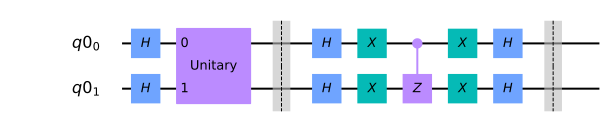

In [3]:
dim = 2
qr= QuantumRegister(dim)
qc = QuantumCircuit(qr)
qc.h(range(dim))
# qreg = QuantumCircuit(qr)

# creating a randomized Grover operator
a = randint(0,2**dim-1)
A = np.identity(2**dim)
A[a,a] = -1
print(A)
Grov = Operator(A)
qc.append(Grov,range(dim))

qc.barrier()
qc.h(range(dim))
qc.x(range(dim))

qc.cz(0,1)
qc.x(range(dim))
qc.h(range(dim))
qc.barrier()
qc.draw(output='mpl')

The expected state is: [-1.96261557e-16+3.69778549e-32j -2.22044605e-16-1.22464680e-16j
 -1.96261557e-16-1.22464680e-16j -1.00000000e+00+2.44929360e-16j]


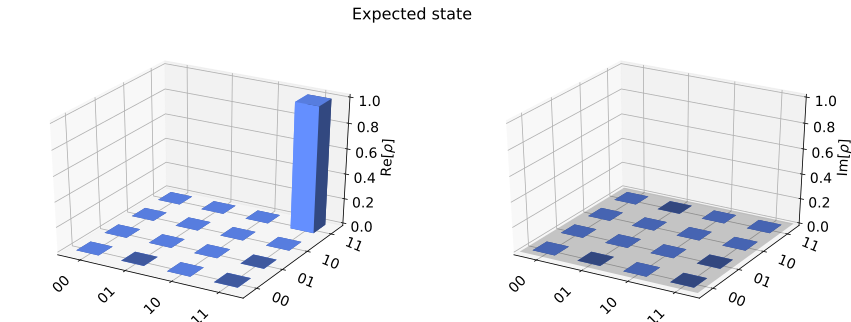

In [4]:
# visualizing the expected state
job = qiskit.execute(qc, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

### Readout correction
This is done by initializing the 2 qbits in 00, 01, 10, 11 and measuring the output

Job Status: job has successfully run


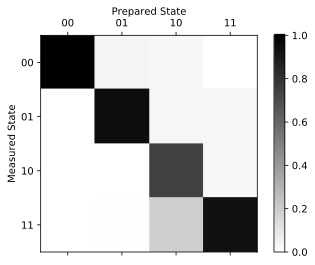

In [5]:
# readout calibration measurement
cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
cal_job = qiskit.execute(cal_circuits,backend = device,shots = 8192,optimization_level = 0,)
job_monitor(cal_job)
calres = cal_job.result()
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()

In [6]:
# post-processing to find the readout error correction
counts = [0,0,0,0]
bits = ['00', '01', '10', '11']
for i in range(4):
    counts[i] = calres.get_counts(cal_circuits[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0

m_IZ = np.zeros(4)
m_ZI = np.zeros(4)
m_ZZ = np.zeros(4)
for i in range(4):
    for num, bit in enumerate(bits):
        if num < 2:
            m_IZ[i] += float(counts[i][bit]) / 8192
        if num > 1:
            m_IZ[i] -= float(counts[i][bit]) / 8192
        if num % 2 == 0:
            m_ZI[i] += float(counts[i][bit]) / 8192
        if num % 2 == 1:
            m_ZI[i] -= float(counts[i][bit]) / 8192
        if num == 0 or num == 3:
            m_ZZ[i] += float(counts[i][bit]) / 8192
        if num == 1 or num == 2:
            m_ZZ[i] -= float(counts[i][bit]) / 8192
            
M = [[1,  1,  1,  1], 
     [1,  1, -1, -1], 
     [1, -1,  1, -1], 
     [1, -1, -1,  1]]
Minv = np.linalg.inv(M)

beta_IZ = np.dot(Minv, m_IZ)
beta_ZI = np.dot(Minv, m_ZI)
beta_ZZ = np.dot(Minv, m_ZZ)

b_vec = [beta_IZ[0], beta_ZI[0], beta_ZZ[0]]
B = [beta_IZ[1:], beta_ZI[1:], beta_ZZ[1:]]
Binv = np.linalg.inv(B)

### State Tomography
In order to reconstruct the output state of the circuit, it is necessary to perform 2 qbit tomography to build an arbitrary state from the outcomes of a series of measurements that together give the full state. For 2 qbits, that is 9 (3^n) circuits.

In [7]:
# defining tomography circuits
qst_circuit = state_tomography_circuits(qc,qr)

In [8]:
backends = ['simulator', 'simulator noise', device]

paulis = [('X','X'),('Y','X'),('Z','X'),
          ('X','Y'),('Y','Y'),('Z','Y'),
          ('X','Z'),('Y','Z'),('Z','Z')]

basis = ['XX','YX','ZX',
         'XY','YY','ZY',
         'XZ','YZ','ZZ']

# running each tomography circuit with each backend
# storing the outcomes in a dictionary for easy access
# during post-processing
for num, backend in enumerate(backends):
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '01': 0, '10': 0, '11': 0}})
    
    if num == 0:
        job_sim = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 1:
        job_sim = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192,
                                 noise_model=noise_model, 
                                 coupling_map=coupling_map, 
                                 basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 2:
        job_dev = qiskit.execute(qst_circuit, backend, shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)
    
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit] = 0
    
    for y,bas in enumerate(basis):
        state.update({bas: {'00': state[bas]['00']+tom.data[paulis[y]][bits[0]],
                            '01': state[bas]['01']+tom.data[paulis[y]][bits[1]],
                            '10': state[bas]['10']+tom.data[paulis[y]][bits[2]],
                            '11': state[bas]['11']+tom.data[paulis[y]][bits[3]]}})

    if num == 0:
        state_sim = state
        print('The full state for the simulator is', state_sim)
    if num == 1:
        state_sim_noise = state
        print('The full state for the noisy simulator is', state_sim_noise)
    if num == 2:
        state_dev = state
        print('The full state for the device is', state_dev)

The full state for the simulator is {'XX': {'00': 2015, '01': 2088, '10': 2065, '11': 2024}, 'YX': {'00': 2084, '01': 2040, '10': 2019, '11': 2049}, 'ZX': {'00': 0, '01': 4107, '10': 0, '11': 4085}, 'XY': {'00': 1968, '01': 2020, '10': 2047, '11': 2157}, 'YY': {'00': 2087, '01': 2119, '10': 1994, '11': 1992}, 'ZY': {'00': 0, '01': 4141, '10': 0, '11': 4051}, 'XZ': {'00': 0, '01': 0, '10': 4112, '11': 4080}, 'YZ': {'00': 0, '01': 0, '10': 4113, '11': 4079}, 'ZZ': {'00': 0, '01': 0, '10': 0, '11': 8192}}
The full state for the noisy simulator is {'XX': {'00': 2104, '01': 1977, '10': 2112, '11': 1999}, 'YX': {'00': 2080, '01': 1982, '10': 2100, '11': 2030}, 'ZX': {'00': 107, '01': 3990, '10': 148, '11': 3947}, 'XY': {'00': 2133, '01': 2050, '10': 2058, '11': 1951}, 'YY': {'00': 2068, '01': 2024, '10': 2095, '11': 2005}, 'ZY': {'00': 108, '01': 4034, '10': 118, '11': 3932}, 'XZ': {'00': 106, '01': 128, '10': 3989, '11': 3969}, 'YZ': {'00': 116, '01': 131, '10': 4068, '11': 3877}, 'ZZ': {'0

In [9]:
# defining the matrices to reconstruct the density matrices
I_matrix = np.matrix('1, 0; 0, 1')
X_matrix = np.matrix('0, 1; 1, 0')
Y_matrix = np.matrix('0, 0-1j; 0+1j, 0')
Z_matrix = np.matrix('1, 0; 0, -1')

Iden = np.kron(I_matrix,I_matrix)

IXPaul = np.kron(I_matrix,X_matrix)
IYPaul = np.kron(I_matrix,Y_matrix)
IZPaul = np.kron(I_matrix,Z_matrix)
XIPaul = np.kron(X_matrix,I_matrix)
YIPaul = np.kron(Y_matrix,I_matrix)
ZIPaul = np.kron(Z_matrix,I_matrix)

XXPaul = np.kron(X_matrix,X_matrix)
XYPaul = np.kron(X_matrix,Y_matrix)
XZPaul = np.kron(X_matrix,Z_matrix)

YXPaul = np.kron(Y_matrix,X_matrix)
YYPaul = np.kron(Y_matrix,Y_matrix)
YZPaul = np.kron(Y_matrix,Z_matrix)

ZXPaul = np.kron(Z_matrix,X_matrix)
ZYPaul = np.kron(Z_matrix,Y_matrix)
ZZPaul = np.kron(Z_matrix,Z_matrix)

In [11]:
# there are 4 density matrices to calculate for each of sim, sim_noise, dev and readout cal

# XX, XY, XZ etc are 9 total r_xx etc terms to calculate
r_exp = np.zeros(9)
# there are three IX type terms and each can be calculated three ways (from XX, YX, ZX for IX)
r_IP = np.zeros(9)
r_PI = np.zeros(9)
r_IPavg = np.zeros(3)
r_PIavg = np.zeros(3)

m = np.zeros((9,3))
r_corr = np.zeros((9,3))
r_IPavg_corr = np.zeros(3)
r_PIavg_corr = np.zeros(3)

state_tot=[state_sim,state_sim_noise,state_dev]
rho = [0,0,0,0]

for stat, states in enumerate(state_tot):
    for j in range(9):
        r_exp[j] = (states[basis[j]]['00']*1 + states[basis[j]]['10']*(-1) + states[basis[j]]['01']*(-1) + states[basis[j]]['11']*1)/(states[basis[j]]['00'] + states[basis[j]]['10'] + states[basis[j]]['01'] + states[basis[j]]['11'])
        r_IP[j] = (states[basis[j]]['00']*1 + states[basis[j]]['10']*(1) + states[basis[j]]['01']*(-1) + states[basis[j]]['11']*(-1))/(states[basis[j]]['00'] + states[basis[j]]['10'] + states[basis[j]]['01'] + states[basis[j]]['11'])
        r_PI[j] = (states[basis[j]]['00']*1 + states[basis[j]]['10']*(-1) + states[basis[j]]['01']*(1) + states[basis[j]]['11']*(-1))/(states[basis[j]]['00'] + states[basis[j]]['10'] + states[basis[j]]['01'] + states[basis[j]]['11'])
            
    for j in range(3):
            r_IPavg[j] = (r_IP[j] + r_IP[j+3] + r_IP[j+6])/3
            r_PIavg[j] = (r_PI[3*j] + r_PI[3*j+1] + r_PI[3*j+2])/3
    
    rho[stat] = (1/4)*(Iden + r_exp[0]*XXPaul + r_exp[1]*XYPaul + r_exp[2]*XZPaul
                          + r_exp[3]*YXPaul + r_exp[4]*YYPaul + r_exp[5]*YZPaul
                          + r_exp[6]*ZXPaul + r_exp[7]*ZYPaul + r_exp[8]*ZZPaul
                          + r_IPavg[0]*IXPaul + r_PIavg[0]*XIPaul
                          + r_IPavg[1]*IYPaul + r_PIavg[1]*YIPaul
                          + r_IPavg[2]*IZPaul + r_PIavg[2]*ZIPaul)


for num, bas in enumerate(basis):
    m[num,:] = [r_IP[num], r_PI[num], r_exp[num]]
    r_corr[num] = np.dot(Binv, np.subtract(m[num,:],b_vec))

for j in range(3):
        r_IPavg_corr[j] = (r_corr[j][0] + r_corr[j+3][0] + r_corr[j+6][0])/3
        r_PIavg_corr[j] = (r_corr[3*j][1] + r_corr[3*j+1][1] + r_corr[3*j+2][1])/3

rho[3] = (1/4)*(Iden + r_corr[0][2]*XXPaul + r_corr[1][2]*XYPaul + r_corr[2][2]*XZPaul
                          + r_corr[3][2]*YXPaul + r_corr[4][2]*YYPaul + r_corr[5][2]*YZPaul
                          + r_corr[6][2]*ZXPaul + r_corr[7][2]*ZYPaul + r_corr[8][2]*ZZPaul
                          + r_IPavg_corr[0]*IXPaul + r_PIavg_corr[0]*XIPaul
                          + r_IPavg_corr[1]*IYPaul + r_PIavg_corr[1]*YIPaul
                          + r_IPavg_corr[2]*IZPaul + r_PIavg_corr[2]*ZIPaul)

### Plotting Ouput States

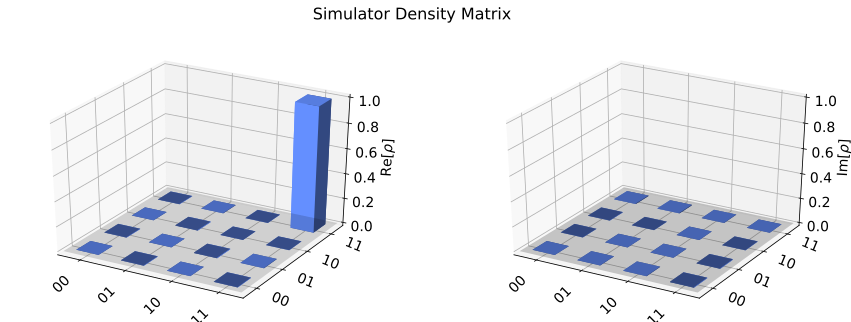

In [12]:
plot_state_city(rho[0], title='Simulator Density Matrix')

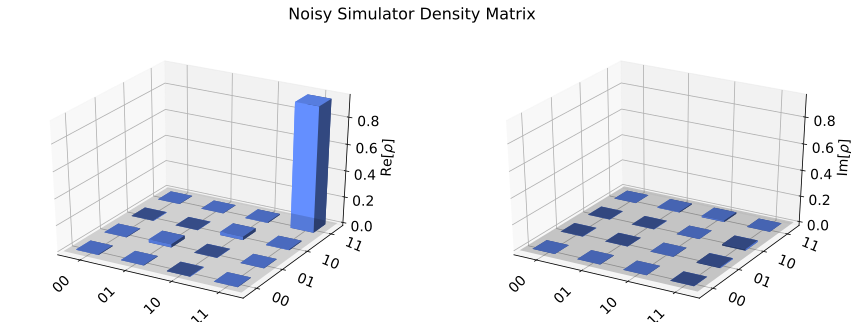

In [13]:
plot_state_city(rho[1], title='Noisy Simulator Density Matrix')

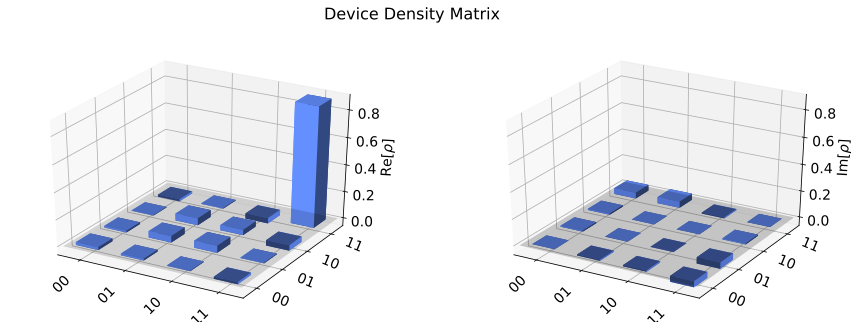

In [14]:
plot_state_city(rho[2], title='Device Density Matrix')

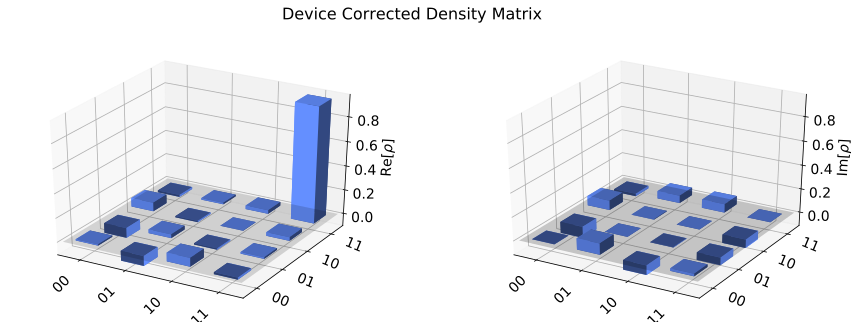

In [15]:
plot_state_city(rho[3], title='Device Corrected Density Matrix')

### Calculating Fidelities

In [16]:
Fidelity = np.zeros(4)
for j in range(4):
    Fidelity[j] = state_fidelity(psi_expected, rho[j], validate=False)     

print('Simulator Fidelity:', Fidelity[0])
print('Noisy Simulator Fidelity:', Fidelity[1])
print('Device Fidelity:', Fidelity[2])
print('Corrected Device Fidelity:', Fidelity[3])

Simulator Fidelity: 1.0
Noisy Simulator Fidelity: 0.9456787109375
Device Fidelity: 0.8899332682291666
Corrected Device Fidelity: 0.9561603004840973


In [17]:
rho_sim = DensityMatrix(rho[0])
rho_dev = DensityMatrix(rho[2])
print('Is the simulator density matrix valid?', rho_sim.is_valid())
print('Is the device density matrix valid?', rho_dev.is_valid())

# The simulator makes an impossible density matrix, which is to be
# expected for a finite number of runs of a circuit

Is the simulator density matrix valid? False
Is the device density matrix valid? False


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table